In [18]:
import sklearn.metrics as skm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import time
import importlib
import scipy.io as sio
from plot_mi_metric import plot_mi_wrt_clusters

In [17]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
# change GPU here
torch.cuda.set_device(2)
print(torch.cuda.current_device())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

True
4
2
cuda


In [3]:
# number of clusters for any model
num_clusters = 5

In [4]:
data_dir = './data/rain'

In [5]:
data = sio.loadmat(data_dir+'/raw_data/rainData.mat')['rainData'][0][0]
train_data = data[1]['sensordata'][0][0]
test_data = data[2]['sensordata'][0][0]
data = np.vstack((train_data, test_data)).T
train_data, test_data = (None,)*2
print(f'data.shape={data.shape}')
# data = data.T

# round figure the number of observations in a timeseries for the sake of convenience in analysis, although not necessary  
data = data[:, :-53]

print(f'data.shape={data.shape}')

data.shape=(167, 9953)
data.shape=(167, 9900)


In [6]:
# number of sensors (to be clustered)
n = data.shape[0]

In [7]:
%%time

import timeseries_dependency_scores as tds
importlib.reload(tds)

# it can be expensive to compute mutual information between every pair of timeseries (167 in this case), which is required for evaluating the clusters, so it's easier to just load it from the data directory
# note that this metric is completely independent in its formulation from the information objective of mutual information for clustering
# this is used only for the purpose for evaluation of clusters from different methods, not for optimizing clusters 
fresh_compute = False

if fresh_compute:
    mi_scores = tds.TimeseriesDependencyScores(metric='mi', num_cores=84).compute_dependency_scores(time_series_data=data)
    np.save(data_dir+'/mi_scores', mi_scores)
else:
    mi_scores = np.load(data_dir+'/mi_scores.npy')

CPU times: user 38.1 ms, sys: 23.1 ms, total: 61.2 ms
Wall time: 136 ms


In [8]:
plt.rcParams['figure.dpi'] = 80

# kNN clustering

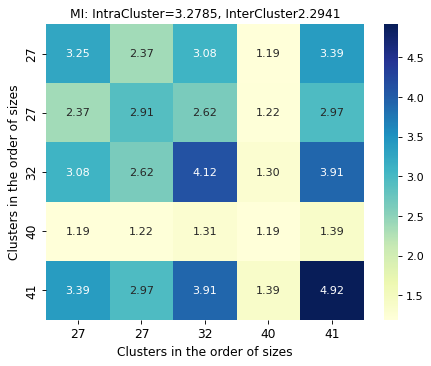

CPU times: user 10min 32s, sys: 3min 26s, total: 13min 59s
Wall time: 6.06 s


In [9]:
%%time

import clustering_evaluator as ce
importlib.reload(ce)

ce_obj = ce.ClusteringEvaluator(num_clusters=num_clusters, seed=0)
kmeans_cluster_labels = ce_obj.cluster_labels_optimize(data=data, cluster_algo='kmeans')

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, kmeans_cluster_labels)

# Spectral clustering

/a/stor125ncs2.virginia.ms.com/sc34972/s182224/venvs/senv/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


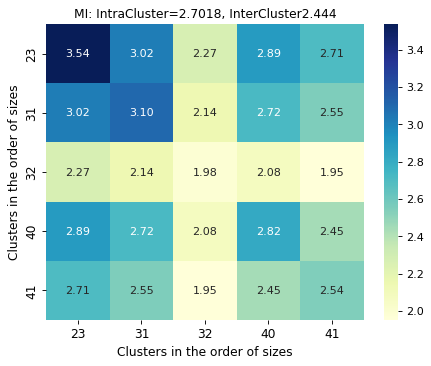

CPU times: user 3.43 s, sys: 3.47 s, total: 6.9 s
Wall time: 235 ms


In [10]:
%%time

import clustering_evaluator as ce
importlib.reload(ce)

ce_obj = ce.ClusteringEvaluator(num_clusters=num_clusters, seed=0)
spectral_cluster_labels = ce_obj.cluster_labels_optimize(data=data, cluster_algo='spectral')

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, spectral_cluster_labels)

# ITC clustering via kNN (using the mutual information objective)

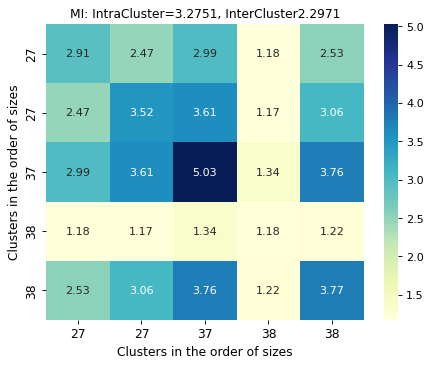

In [11]:
import clustering_evaluator as ce
importlib.reload(ce)

ce_obj = ce.ClusteringEvaluator(num_clusters=num_clusters, seed=0)
sampler = np.random.RandomState(seed=0)
itc_knn_cluster_labels = ce_obj.cluster_labels_optimize(cluster_algo='itc_knn',
    data=data+1e-100*sampler.rand(data.shape[0], data.shape[1])
)

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, itc_knn_cluster_labels)

# ITC clustering via minimum spanning tree (using the mutual information objective)

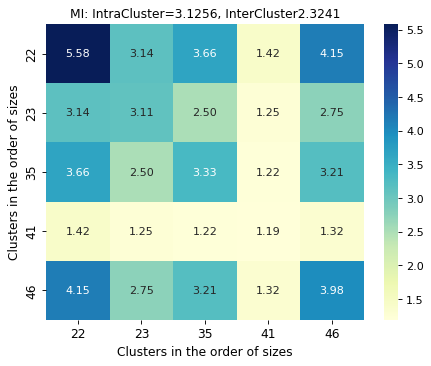

CPU times: user 713 ms, sys: 453 ms, total: 1.17 s
Wall time: 391 ms


In [12]:
%%time

import clustering_evaluator as ce
importlib.reload(ce)

ce_obj = ce.ClusteringEvaluator(num_clusters=num_clusters, seed=0)
sampler = np.random.RandomState(seed=0)
itc_mst_cluster_labels = ce_obj.cluster_labels_optimize(cluster_algo='itc_mst',
    data=data+1e-10*sampler.rand(data.shape[0], data.shape[1]),
)

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, itc_mst_cluster_labels)

# Our ITC-DM approach with LSTMs

....................................................................................................Cluster Sizes [ 61 106]
....................................................................................................Cluster Sizes [61 14 92]
....................................................................................................Cluster Sizes [61 14 10 82]
....................................................................................................Cluster Sizes [61 14 10  8 74]
................................

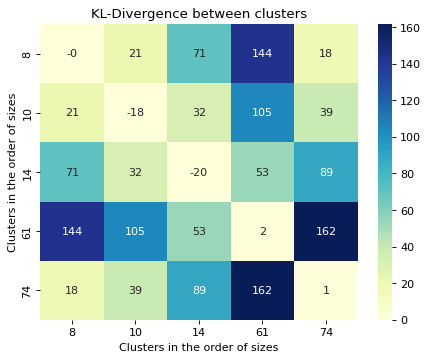

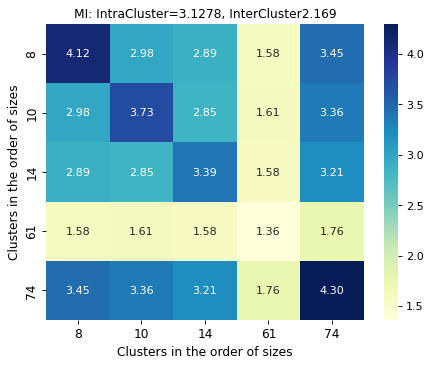

CPU times: user 42.9 s, sys: 1.93 s, total: 44.8 s
Wall time: 57.4 s


In [ ]:
%%time

import info_theoretic_kl_div_clustering as itdvo
importlib.reload(itdvo)

itdvo_obj = itdvo.NeuralKLDivClustering(seed=0, debug=False)

cluster_labels_itc_dv_lstm = itdvo_obj.optimize_multiple_clusters_maximize_kl_div_greedy(
    # 100 observations of a timeseries are processed in a single timestep  
    X_org=data.reshape(data.shape[0], -1, 100),
    num_layers=2,
    hidden_size=32,
    num_clusters=num_clusters,
    nn='lstm',
    device=device,
)

# this is used for manual tuning of some of the hyperparameters such as number of layers, number of hidden units, etc.
# results for only the final (manual tuned) configuration are considered here.
# there is a separate notenbook for analyzing sensitivity of the results
# simple lighterweight architecture to estimate KL-divergence relative to the one used for optimization     
# transformers are preferred for evaluation for their robustness     
_, _ = itdvo_obj.estimate_kl_div_btw_clusters(
     # 100 observations of a timeseries are processed in a single timestep  
     X=data.reshape(data.shape[0], -1, 100),
     c=cluster_labels_itc_dv_lstm,
     num_layers=1,
     hidden_size=32,
     device=device,
)

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, cluster_labels_itc_dv_lstm)

# Our ITC-DM approach with Transformers

....................................................................................................Cluster Sizes [ 54 113]
....................................................................................................Cluster Sizes [54 31 82]
....................................................................................................Cluster Sizes [54 31  9 73]
....................................................................................................Cluster Sizes [54 31  9  8 65]
........................................

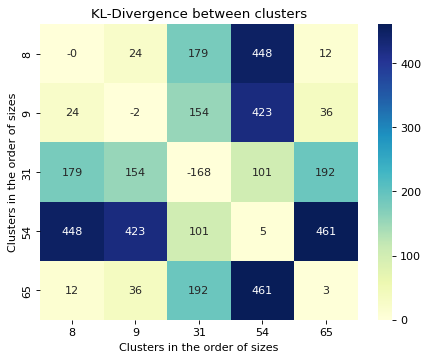

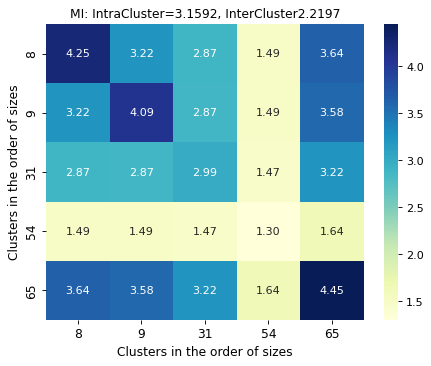

CPU times: user 1min 42s, sys: 1.45 s, total: 1min 43s
Wall time: 1min 41s


In [14]:
%%time

import info_theoretic_kl_div_clustering as itdvo
importlib.reload(itdvo)

itdvo_obj = itdvo.NeuralKLDivClustering(seed=0, debug=False)

cluster_labels_itc_dv_transformer = itdvo_obj.optimize_multiple_clusters_maximize_kl_div_greedy(
    # 100 observations of a timeseries are processed in a single timestep  
    X_org=data.reshape(data.shape[0], -1, 100),
    num_layers=2,
    hidden_size=32,
    num_clusters=num_clusters,
    device=device,
    nn='transformer',
)

# this is used for manual tuning of some of the hyperparameters such as number of layers, number of hidden units, etc.
# results for only the final (manual tuned) configuration are considered here.
# there is a separate notenbook for analyzing sensitivity of the results
# simple lighterweight architecture to estimate KL-divergence relative to the one used for optimization     
# transformers are preferred for evaluation for their robustness     
_, _ = itdvo_obj.estimate_kl_div_btw_clusters(
    # 100 observations of a timeseries are processed in a single timestep  
     X=data.reshape(data.shape[0], -1, 100),
     c=cluster_labels_itc_dv_transformer,
     num_layers=1,
     hidden_size=32,
     device=device,
     nn='transformer',
)

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, cluster_labels_itc_dv_transformer)

# Our ITC-DM approach with FNNs

....................................................................................................Cluster Sizes [151  16]
....................................................................................................Cluster Sizes [ 15  16 136]
....................................................................................................Cluster Sizes [ 15  16  26 110]
....................................................................................................Cluster Sizes [15 16 26 11 99]
........................

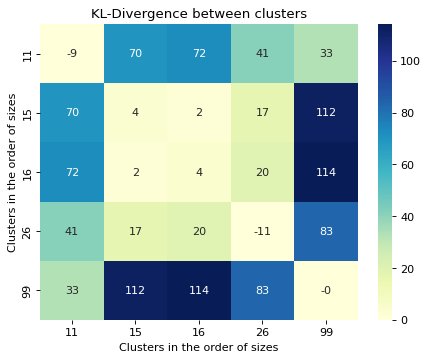

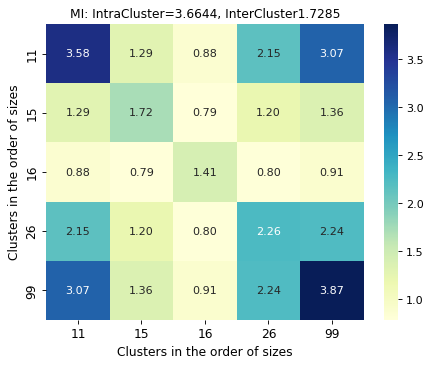

CPU times: user 34.2 s, sys: 558 ms, total: 34.7 s
Wall time: 33.3 s


In [15]:
%%time

import info_theoretic_kl_div_clustering as itdvo
importlib.reload(itdvo)

itdvo_obj = itdvo.NeuralKLDivClustering(seed=0, debug=False)

cluster_labels_itc_dv_fnn = itdvo_obj.optimize_multiple_clusters_maximize_kl_div_greedy(
    X_org=data,
    num_layers=3,
    hidden_size=32,
    num_clusters=num_clusters,
    device=device,
    nn='fnn',
)

# this is used for manual tuning of some of the hyperparameters such as number of layers, number of hidden units, etc.
# results for only the final (manual tuned) configuration are considered here.
# there is a separate notenbook for analyzing sensitivity of the results
# simple lighterweight architecture to estimate KL-divergence relative to the one used for optimization     
# transformers are preferred for evaluation for their robustness     
_, _ = itdvo_obj.estimate_kl_div_btw_clusters(
    # 100 observations of a timeseries are processed in a single timestep  
     X=data.reshape(data.shape[0], -1, 100),
     c=cluster_labels_itc_dv_fnn,
     num_layers=1,
     hidden_size=32,
     device=device,
     nn='transformer',
)

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, cluster_labels_itc_dv_fnn)